In [106]:
import pandas as pd
from itertools import product
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

In [107]:
def load_and_grid_data(file_path='./data/roadworks.csv', date_filter=('2024-01-01', '2025-10-04')):
    """Загрузка CSV, фильтр по датам, полный грид с 0."""
    df = pd.read_csv(file_path)
    df['start_date'] = pd.to_datetime(df['start_date'])
    df['end_date'] = pd.to_datetime(df['end_date'])
    df['week_start'] = df['start_date'].dt.to_period('W').dt.start_time
    
    if date_filter[0]:
        df = df[(df['start_date'] >= date_filter[0]) & (df['start_date'] <= date_filter[1])]
    
    print(f"Размер датасета после фильтра: {df.shape}")
    print(df.head())
    
    actual_counts = df.groupby(['okrug_name', 'week_start']).size().reset_index(name='repair_count')
    
    unique_okrugs = df['okrug_name'].unique()
    min_date = df['week_start'].min()
    max_date = df['week_start'].max()
    all_weeks = pd.date_range(start=min_date, end=max_date, freq='W-MON')
    
    all_combos = list(product(unique_okrugs, all_weeks))
    full_grid = pd.DataFrame(all_combos, columns=['okrug_name', 'week_start'])
    full_df = full_grid.merge(actual_counts, on=['okrug_name', 'week_start'], how='left')
    full_df['repair_count'] = full_df['repair_count'].fillna(0).astype(int)
    
    print(f"Полный грид: {full_df.shape}")
    return full_df, df

full_df, orig_df = load_and_grid_data()

Размер датасета после фильтра: (1818, 16)
                                   uuid          start_date  \
0  003d3e8e-087d-4901-8d86-e29985ea6248 2025-08-02 00:01:00   
1  00404245-adbe-4ee0-9e32-90c1ef346466 2025-08-16 00:01:00   
2  005b7020-5fbc-4890-b08e-156f2e440ac2 2025-07-14 00:01:00   
3  005ffb59-710e-454e-b781-87df46d9f46c 2025-07-01 00:01:00   
4  00620b7f-e669-4372-bcbb-a5f9ffb949e7 2025-08-02 05:00:00   

             end_date                      worker  \
0 2025-08-10 23:59:00   ООО "Профстройтехнолоджи"   
1 2025-08-22 23:59:00  ГБУ «Автомобильные дороги»   
2 2025-07-22 23:59:00           АО "Мосводоканал"   
3 2025-07-07 23:59:00           ООО «БТС Холдинг»   
4 2025-08-02 15:00:00               АНО «Москино»   

                                                work  \
0                                          Теплосеть   
1  Проведение работ по объекту: «Выполнение работ...   
2                                         Водопровод   
3  Проведение работ по объекту: «Вын

In [108]:
def prepare_features(full_df, orig_df):
    """Лаги, target на t+1, доп. фичи, summary."""
    full_df = full_df.sort_values(['okrug_name', 'week_start']).copy()
    full_df['prev_count'] = full_df.groupby('okrug_name')['repair_count'].shift(1)
    
    full_df['next_repair_count'] = full_df.groupby('okrug_name')['repair_count'].shift(-1)
    full_df['has_repair'] = (full_df['next_repair_count'] > 0).astype(int)
    
    avg_closed = orig_df.groupby(['okrug_name', 'week_start'])['closed_lines'].mean().reset_index(name='avg_closed_lines')
    full_df = full_df.merge(avg_closed, on=['okrug_name', 'week_start'], how='left')
    full_df['avg_closed_lines'] = full_df['avg_closed_lines'].fillna(0)
    
    speed_flag = orig_df.groupby(['okrug_name', 'week_start'])['speed_reduced'].mean().reset_index(name='low_speed_flag')
    full_df = full_df.merge(speed_flag, on=['okrug_name', 'week_start'], how='left')
    full_df['low_speed_flag'] = (full_df['low_speed_flag'] < 40).astype(int).fillna(0)
    
    full_df['is_summer'] = ((full_df['week_start'].dt.month >= 6) & (full_df['week_start'].dt.month <= 9)).astype(int)
    
    model_df = full_df.dropna(subset=['prev_count', 'has_repair']).copy()
    model_df['high_prev'] = (model_df['prev_count'] > 1).astype(int)
    
    print("Распределение классов в has_repair (на t+1):")
    print(model_df['has_repair'].value_counts())
    print(f"\nУникальные округа: {model_df['okrug_name'].nunique()}")
    print("\nПервые строки model_df:")
    print(model_df.head())
    
    # Summary
    okrug_summary = model_df.groupby('okrug_name')['has_repair'].agg(
        total_weeks='count',
        repair_weeks='sum',
        repair_rate='mean'
    ).round(4).sort_values('repair_rate', ascending=False)
    print("\nSummary по округам (repair_rate на t+1):")
    print(okrug_summary)
    
    return model_df, okrug_summary, full_df

model_df, summary_okrugs, full_df = prepare_features(full_df, orig_df)

Распределение классов в has_repair (на t+1):
has_repair
0    710
1    286
Name: count, dtype: int64

Уникальные округа: 12

Первые строки model_df:
                         okrug_name week_start  repair_count  prev_count  \
1  административный округ Восточный 2024-01-22             0         0.0   
2  административный округ Восточный 2024-01-29             0         0.0   
3  административный округ Восточный 2024-02-05             0         0.0   
4  административный округ Восточный 2024-02-12             0         0.0   
5  административный округ Восточный 2024-02-19             0         0.0   

   next_repair_count  has_repair  avg_closed_lines  low_speed_flag  is_summer  \
1                0.0           0               0.0               0          0   
2                0.0           0               0.0               0          0   
3                0.0           0               0.0               0          0   
4                0.0           0               0.0               0     

In [115]:
from sklearn.metrics import classification_report


def train_and_evaluate(model_df):
    """Обучение с time-based split (без shuffle), доп. метрики."""
    X = model_df[['prev_count', 'high_prev', 'avg_closed_lines', 'low_speed_flag', 'is_summer']]
    y = model_df['has_repair']
    
    if len(y.unique()) < 2:
        print("Внимание: Только один класс!")
        return None
    
    split_idx = int(0.7 * len(model_df))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    
    top_k = int(0.05 * len(y_test))
    top_indices = np.argsort(y_proba)[-top_k:]
    recall_k = recall_score(y_test.iloc[top_indices], np.ones(top_k), average='macro')
    
    brier = np.mean((y_proba - y_test) ** 2)
    
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f} | PR-AUC: {pr_auc:.3f} | Recall@top5%: {recall_k:.3f} | Brier: {brier:.3f}")
    print("\nОтчёт по классам:")
    print(classification_report(y_test, y_pred))
    print(f"\nКоэффициенты: prev_count={model.coef_[0][0]:.3f}, high_prev={model.coef_[0][1]:.3f}, ...")
    
    return model

model = train_and_evaluate(model_df)

Accuracy: 0.789 | ROC-AUC: 0.838 | PR-AUC: 0.762 | Recall@top5%: 0.500 | Brier: 0.151

Отчёт по классам:
              precision    recall  f1-score   support

           0       0.78      0.92      0.85       187
           1       0.81      0.57      0.67       112

    accuracy                           0.79       299
   macro avg       0.80      0.75      0.76       299
weighted avg       0.79      0.79      0.78       299


Коэффициенты: prev_count=0.181, high_prev=1.642, ...



Предсказания на 2025-11-07 (is_summer=0):
                                 okrug_name  predicted_prob recommendation
8        административный округ Центральный           0.993      Обходить!
1           административный округ Западный           0.872      Обходить!
4           административный округ Северный           0.850      Обходить!
5   административный округ Северо-Восточный           0.741      Обходить!
10      административный округ Юго-Западный           0.705      Обходить!
9      административный округ Юго-Восточный           0.625      Проезжаем
0          административный округ Восточный           0.537      Проезжаем
2     административный округ Зеленоградский           0.491      Проезжаем
11             административный округ Южный           0.491      Проезжаем
3     административный округ Новомосковский           0.135      Проезжаем
6    административный округ Северо-Западный           0.135      Проезжаем
7           административный округ Троицкий           0.1

<Figure size 1200x600 with 0 Axes>

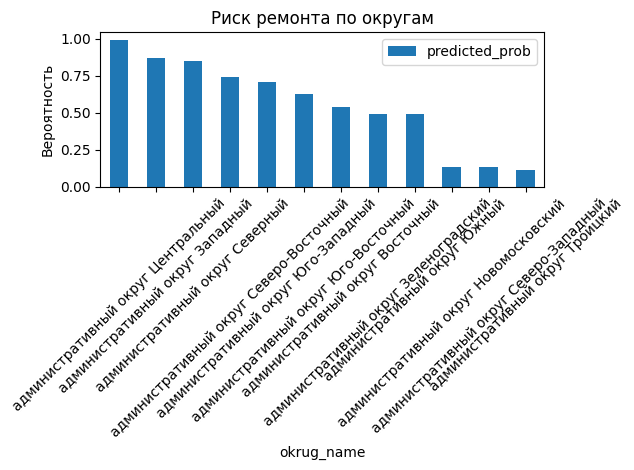

In [116]:
def predict_risk(model, full_df, next_week_date=pd.to_datetime('2025-11-07'), threshold=0.7):
    """Предсказания для следующей недели (с чеком)."""
    if 'prev_count' not in full_df.columns:
        raise ValueError("prev_count отсутствует! Запусти prepare_features.")
    
    last_df = full_df.groupby('okrug_name').last().reset_index()
    if last_df['prev_count'].isna().any():
        last_df['prev_count'] = last_df['prev_count'].fillna(0)
    
    last_df['high_prev'] = (last_df['prev_count'] > 1).astype(int)
    last_df['avg_closed_lines'] = last_df.get('avg_closed_lines', pd.Series(0, index=last_df.index)).fillna(0)
    last_df['low_speed_flag'] = last_df.get('low_speed_flag', pd.Series(0, index=last_df.index)).fillna(0)
    
    is_summer_scalar = int((next_week_date.month >= 6) & (next_week_date.month <= 9))
    last_df['is_summer'] = is_summer_scalar
    
    X_pred = last_df[['prev_count', 'high_prev', 'avg_closed_lines', 'low_speed_flag', 'is_summer']]
    last_df['predicted_prob'] = model.predict_proba(X_pred)[:, 1]
    
    predictions = last_df[['okrug_name', 'predicted_prob']].sort_values('predicted_prob', ascending=False).round(3)
    predictions['recommendation'] = np.where(predictions['predicted_prob'] > threshold, 'Обходить!', 'Проезжаем')
    
    print(f"\nПредсказания на {next_week_date.date()} (is_summer={is_summer_scalar}):")
    print(predictions)
    
    plt.figure(figsize=(12, 6))
    predictions.plot(x='okrug_name', y='predicted_prob', kind='bar')
    plt.title('Риск ремонта по округам')
    plt.ylabel('Вероятность')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return predictions

if model:
    predictions = predict_risk(model, full_df)